In [59]:
import os
import warnings
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import ruptures as rpt
import ast
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

In [158]:
os.chdir('../src/')
warnings.filterwarnings('ignore')

In [172]:
import os
import warnings
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

def process_file(filename, data_path):
    df = pd.read_csv(f'{data_path}/{filename}', names=['time', 'pressure'], sep='\\s+')
    
    scaler = StandardScaler()
    df[['time_scaled', 'pressure_scaled']] = scaler.fit_transform(df[['time', 'pressure']])
    
    eps_value = 0.085
    dbscan = DBSCAN(eps=eps_value, min_samples=20)
    df['cluster'] = dbscan.fit_predict(df[['time_scaled', 'pressure_scaled']])
    df['cluster'] = df['cluster'].apply(lambda x: 1 if x == -1 else 0)
    
    df['segment_id'] = (df['cluster'] != df['cluster'].shift()).cumsum()
    segment_sizes = df.groupby('segment_id')['cluster'].transform('sum')
    df['clean_cluster'] = np.where((df['cluster'] == 1) & (segment_sizes >= 40), 1, 0)
    
    df['delta_pressure'] = df['pressure'].diff().rolling(3, center=True).mean()
    df['final_cluster'] = 0
    df.loc[(df['clean_cluster'] == 1) & (df['delta_pressure'] < 0), 'final_cluster'] = 1
    df.loc[(df['clean_cluster'] == 1) & (df['delta_pressure'] > 0), 'final_cluster'] = 2
    
    df['segment_id'] = (df['final_cluster'] != df['final_cluster'].shift()).cumsum()
    segment_sizes = df.groupby('segment_id')['final_cluster'].transform('count')
    df.loc[segment_sizes < 5, 'final_cluster'] = 0
    
    df['segment_id'] = (df['cluster'] != df['cluster'].shift()).cumsum()
    drop_segments = []
    recovery_segments = []
    
    for _, group in df.groupby('segment_id'):
        cluster_type = group['final_cluster'].iloc[0]
        start_time = group['time'].iloc[0]
        end_time = group['time'].iloc[-1]
        
        if cluster_type == 1:
            drop_segments.append([start_time, end_time])
        elif cluster_type == 2:
            recovery_segments.append([start_time, end_time])
    
    def merge_intervals(segments, gap_threshold=50):
        merged = []
        for interval in segments:
            if not merged or interval[0] - merged[-1][1] > gap_threshold:
                merged.append(interval)
            else:
                merged[-1][1] = interval[1]
        return merged
    
    merged_drop_segments = merge_intervals(drop_segments)
    merged_recovery_segments = merge_intervals(recovery_segments)
    
    return filename, merged_recovery_segments, merged_drop_segments

def process_all_files(input_path, data_path, output_path):
    submit_df = pd.read_csv(input_path)
    results = []
    
    for file in submit_df['file']:
        filename, recovery, drop = process_file(file, data_path)
        results.append({'file': filename, 'recovery': recovery, 'drop': drop})
    
    output_df = pd.DataFrame(results)
    output_df.to_csv(output_path, index=False)

SUBMIT_INPUT_PATH = "../src/raw_data/submit.csv"
SUBMIT_OUTPUT_PATH = "../src/submit2.csv"
DATA_PATH = "../src/raw_data/test"

process_all_files(SUBMIT_INPUT_PATH, DATA_PATH, SUBMIT_OUTPUT_PATH)


In [159]:
labels_df = pd.read_csv('raw_data/ground_truth.csv', sep = ';')
labels_df

,file,mark,recovery,drop
0,00e03657-8e1e-4c8c-a724-1d3c77b48510,"[0.0,235.9225,237.06666666666666,2076.06055555...","[[2419.9805555555554,2437.4241666666667],[3177...","[[3453.6875,3763.9605555555554]]"
1,00e4dba2-36d2-42b4-beb1-c55aed75f506,"[0.0,7979.234444444444,13284.465,19439.8005555...",[],"[[13284.465,19439.800555555557]]"
2,00f035b7-ad7a-4f30-9081-522a3c10805b,"[0.0,42.75,2438.3330555555553]",[],"[[0.0,42.75]]"
3,01a0c034-6afc-4e73-95fa-621f702a0b7d,"[0.0,491.98305555555555,1439.9830555555557,154...",[],"[[0.0,491.98305555555555]]"
4,01a530d3-6496-4515-9fbb-4f44e298fd29,"[0.0,1287.0341666666666,1288.0483333333334,156...",[],"[[4920.376666666667,6208.231666666667]]"
...,...,...,...,...
95,1dfaf03c-e297-4d92-a0bf-40b1a829391f,"[0.0,7.4,7.933055555555556,14.466666666666667,...",[],[]
96,1e149fbd-41c6-4779-b87d-c5dc17fbb4c0,"[0.0,635.3127777777778]",[],"[[0.0,635.3127777777778]]"
97,1e19b77c-8a0e-4749-a384-9c1e679035bf,"[0.0,82.16555555555556,216.66027777777776,229....",[],[]
98,1e4b4c18-1e32-45eb-917a-5760e33fbaca,"[0.0,1217.8258333333333,1223.6030555555556,125...","[[9541.77638888889,10288.5075]]","[[10339.343055555555,10739.613055555556],[1311..."


In [160]:
filename = labels_df['file'][0]
recovery = ast.literal_eval(labels_df['recovery'][0])
drop = ast.literal_eval(labels_df['drop'][0])
df = pd.read_csv(f'train_denoised/{filename}', names = ['time', 'pressure'], sep = '\\s+')

In [161]:
def check_range(t):
    for start, end in recovery:
        if start <= t <= end:
            return 1  
    for start, end in drop:
        if start <= t <= end:
            return 1  
    return 0  

df['label'] = df['time'].apply(check_range)
clust_df = df.copy()

In [162]:
scaler = StandardScaler()
clust_df[['time_scaled', 'pressure_scaled']] = scaler.fit_transform(clust_df[['time', 'pressure']])

neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(clust_df[['time_scaled', 'pressure_scaled']])
distances, indices = neighbors_fit.kneighbors(clust_df[['time_scaled', 'pressure_scaled']])

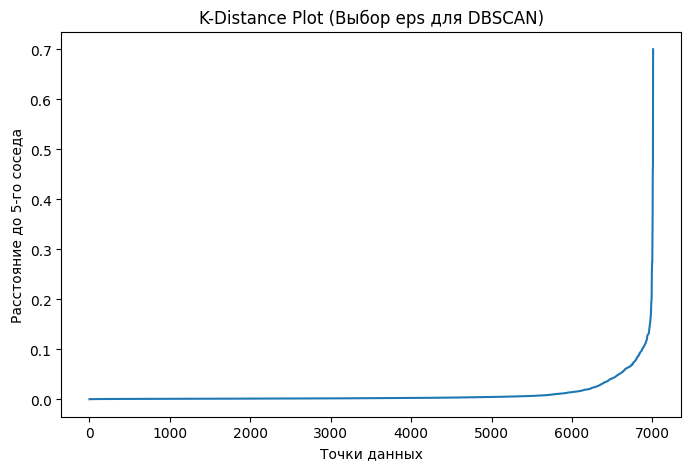

In [163]:
# Сортируем расстояния и строим график
distances = np.sort(distances[:, 4], axis=0)
plt.figure(figsize=(8, 5))
plt.plot(distances)
plt.xlabel("Точки данных")
plt.ylabel("Расстояние до 5-го соседа")
plt.title("K-Distance Plot (Выбор eps для DBSCAN)")
plt.show()

In [ ]:
eps_value = 0.085
dbscan = DBSCAN(eps=eps_value, min_samples=20)  
clust_df['cluster'] = dbscan.fit_predict(clust_df[['time_scaled', 'pressure_scaled']])

clust_df['cluster'] = clust_df['cluster'].apply(lambda x: 1 if x == -1 else 0)

clust_df['segment_id'] = (clust_df['cluster'] != clust_df['cluster'].shift()).cumsum()
segment_sizes = clust_df.groupby('segment_id')['cluster'].transform('sum')

min_cluster_length = 40
clust_df['clean_cluster'] = np.where((clust_df['cluster'] == 1) & (segment_sizes >= min_cluster_length), 1, 0)

clust_df['delta_pressure'] = clust_df['pressure'].diff().rolling(3, center=True).mean()

clust_df['final_cluster'] = 0
clust_df.loc[(clust_df['clean_cluster'] == 1) & (clust_df['delta_pressure'] < 0), 'final_cluster'] = 1
clust_df.loc[(clust_df['clean_cluster'] == 1) & (clust_df['delta_pressure'] > 0), 'final_cluster'] = 2

clust_df['segment_id'] = (clust_df['final_cluster'] != clust_df['final_cluster'].shift()).cumsum()
segment_sizes = clust_df.groupby('segment_id')['final_cluster'].transform('count')
clust_df.loc[segment_sizes < 5, 'final_cluster'] = 0

clust_df.loc[segment_sizes < 5, 'final_cluster'] = 0

clust_df = clust_df[['time', 'pressure', 'final_cluster']]
clust_df.rename(columns={'final_cluster': 'cluster'}, inplace=True)

fig = go.Figure()
colors = {0: "blue", 1: "red", 2: "green"}

for cluster in clust_df["cluster"].unique():
    cluster_data = clust_df[clust_df["cluster"] == cluster]
    marker_symbol = "circle" if cluster != 0 else "x"
    fig.add_trace(go.Scatter(
        x=cluster_data["time"], 
        y=cluster_data["pressure"],
        mode="markers",
        marker=dict(size=6, symbol=marker_symbol, color=colors.get(cluster, "black")),
        name=f"Cluster {cluster}"
    ))

fig.update_layout(
    title="DBSCAN Clustering (объединение близких сегментов `drop` и `recovery`)",
    xaxis_title="Time",
    yaxis_title="Pressure",
    showlegend=True
)

fig.show()

In [75]:
def plot_data(df: pd.DataFrame, indicators_df: pd.DataFrame, filename: str):
    events = indicators_df[indicators_df["file"] == filename][["recovery", "drop"]].values[0]
    recovery_intervals = eval(events[0]) if isinstance(events[0], str) else []
    drop_intervals = eval(events[1]) if isinstance(events[1], str) else []

    fig = px.scatter(df, x = 'time', y = 'pressure', title = f'Visualization of {filename}')
    fig.update_layout(xaxis_title="Time", yaxis_title="Pressure", template="plotly_white")

    for start, end in recovery_intervals:
        fig.add_vrect(x0=start, x1=end, fillcolor="green", opacity=0.3, layer="below", line_width=0, name="Recovery")
        fig.add_trace(go.Scatter(x=[start, end], y=[df["pressure"].max(), df["pressure"].max()],
                                    mode="lines", line=dict(color="green", width=4), name="Recovery (Bold)"))

    for start, end in drop_intervals:
        fig.add_vrect(x0=start, x1=end, fillcolor="red", opacity=0.3, layer="below", line_width=0, name="Drop")
        fig.add_trace(go.Scatter(x=[start, end], y=[df["pressure"].min(), df["pressure"].min()],
                                    mode="lines", line=dict(color="red", width=4), name="Drop (Bold)"))
    
    fig.update_layout(
        xaxis=dict(rangeslider=dict(visible=True), type="linear"),
        yaxis=dict(fixedrange=False),
        legend=dict(title="Legend", x=0.99, y=0.99, xanchor="right", yanchor="top")
        )
    
    fig.show()

filename = labels_df['file'][0]
recovery = ast.literal_eval(labels_df['recovery'][0])
drop = ast.literal_eval(labels_df['drop'][0])
df = pd.read_csv(f'train_reduced/{filename}', names = ['time', 'pressure'], sep = '\\s+')


plot_data(df, labels_df[labels_df['file'] == filename], filename)
print(filename)


00e03657-8e1e-4c8c-a724-1d3c77b48510


In [152]:
clust_df

,time,pressure,cluster
0,5.428611,0.306118,0
1,7.873889,0.306245,0
2,9.584444,0.306394,0
3,10.188889,0.306482,0
4,11.370556,0.306657,0
...,...,...,...
7005,9491.673056,0.086219,0
7006,9494.542222,0.086498,0
7007,9494.935556,0.086741,0
7008,9496.031944,0.087020,0


In [155]:
# Группировка по segment_id, чтобы найти временные границы
clust_df['segment_id'] = (clust_df['cluster'] != clust_df['cluster'].shift()).cumsum()

# Получаем границы сегментов для каждого кластера
drop_segments = []
recovery_segments = []

for segment_id, group in clust_df.groupby('segment_id'):
    cluster_type = group['cluster'].iloc[0]
    start_time = group['time'].iloc[0]
    end_time = group['time'].iloc[-1]
    
    if cluster_type == 1:  # Drop
        drop_segments.append([start_time, end_time])
    elif cluster_type == 2:  # Recovery
        recovery_segments.append([start_time, end_time])



drop_segments, recovery_segments

# Функция объединения близких интервалов
def merge_intervals(segments, gap_threshold=50):
    merged = []
    for interval in segments:
        if not merged or interval[0] - merged[-1][1] > gap_threshold:
            merged.append(interval)
        else:
            merged[-1][1] = interval[1]  # Объединяем интервалы
    return merged

# Объединяем близкие дропы и рекавери
merged_drop_segments = merge_intervals(drop_segments, gap_threshold=50)
merged_recovery_segments = merge_intervals(recovery_segments, gap_threshold=50)

merged_drop_segments, merged_recovery_segments


([[2077.248333, 2164.368333], [3454.225, 3576.167222]],
 [[3172.943333, 3305.753889]])